# **Simulating a LCDM (Lambda Cold Dark-Matter) Universe**

## **LCDM Implementation Improvements**
In the last notebook, we successfully implementated a basic particle-mesh simulation that represents the evolution of particles based on current cosmological parameters. We demonstrated the usage of both the Euler's method and Runge-Kutta method for scaling factor $a$ updates.

Our codebase we have created so far is a ***time-based*** implementation:
  - We use physical time ($Δt$ in Myr) to update our scaling factor $a$, based on the Hubble parameter $H(a)$. Thus, our ***integration variable*** used for the leapfrog integration(s) is our physical time $t$.
  - Since our simulation will be updated in physical time, we had to use conversion factors to convert our simulation units (comoving units $\frac{Mpc}{h}$ to physical units $km/s, Myr$.
  - Our final scaling factor $a$ will thus be determined by the fixed number of timesteps and our $Δt$, so that the final scaling factor $a$ will based on $timesteps_\text{n} * Δt$:


Now, we will continue improving our codebase:

**Explicit grid parameter initializations:**

Our current **N** parameter determines the grid size, which defines the simulation's resolution (grid cells per dimension). It also determines the number of particles per dimension. We can separate these into two variables so that we can handle the case if the number of particles per dimension is NOT the same as the number of grid cells per dimension.
  - **N_particles:** The number of particles per dimension.
  - **N_grid_cells:** The number of grid cells per dimension.

Our current **N** was 128... we can increase this value by power of 2 to increase the simulation's resolution.

The parameter **L** determines the physical box size of the simulation, in comoving units $\frac{Mpc}{h}$. It was initially set to 1000. Lets decrease this value by an OOM to better reflect our simulation's scale so that we can observe the evolution of our particles on a more granular level:
  - **L = 1000$\frac{Mpc}{h}$** for larger galaxy/cluster-level cosmological scales.
  - **L = 100$\frac{Mpc}{h}$** for smaller, galaxy-level cosmological scales.

**Explicit cosmological parameter initializations:**

Can explicitly define our cosmology constants, then use these to define a new cosmology object using these constants, via the `FlatLambdaCDM` class in `astropy.cosmology`
- **H0_val:** The Hubble Constant at *z=0*.
- **Om0:** The matter-density parameter at *z=0*.
- **Ob0:** The baryonic-matter-density parameter at *z=0*.
- **Ok0:** The curvature parameter at *z=0*.
- **Ode0:** The dark-energy-density parameter at *z=0*.
- **Tcmb0:** The temperature of the CMB at *z=0*.
- **cosmo:** A new `FlatLambdaCDM` instance using the cosmological parameters.

Then we can use this new class instance to get our initial cosmological values like the linear growth factor, growth rate, etc using these cosmo params.

**Explicit Growth Rate f(z) function:**

Recall that the growth rate $f(z)$ parameter quantifies how fast density perturbations in the universe grows due to the gravitational attraction. Formally, its defined as: $f(a) = \frac{dlnD}{dlna}$. Its the logarithmic derivative of $D$ wrt. the scaling factor or redshift.

In order to solve this expression analytically we need $D(a)$, however its complex to solve, thus we can use an approximate form commonly used: $f(z) = Ω_\text{m}(z)^γ$, where $γ$ is the growth index and is typically ~ 0.55.

**Explicit Growth Factor D(z) function:**

The growth factor $D(z)$ describes how the amplitude of the density perturbations evolves with redshift $z$ (or alternatively scaling factor $a$). Formally, its the integration of $f(z)$.

We can solve this analytically using an approximation, or numerically by solving an ODE.
  - Approximation is from Carroll, Press and Turner (1992).
  - $D(z) \propto (1+z)^{-1} \, g(z)$, where:
  - $g(z) = \frac{\dfrac{5 \, \Omega_m(z)}{2}}{
    \Omega_m(z)^{4/7} - \Omega_\Lambda(z) +
    \left(1 + \dfrac{\Omega_m(z)}{2}\right)
    \left(1 + \dfrac{\Omega_\Lambda(z)}{70}\right)
}$

Since we know that our $D(z)$ will be ~ 0.01 given the high redshift $z=99$, our functions should reflect that. Using the CPT approximation, at $z=99$, our result will be smaller than this value, meaning that this approx will not work well for our high redshift, thus we can solve $D(z)$ numericall via ODE to get a better result.

Other parameters we have used like the spectral index **ns** and amplitude normalization **A** remains the same.

Here is our new parameter setup using these changes:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Use astropy units for clarity in conversions
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import odeint
from scipy.interpolate import interp1d

RANDOM_SEED = 43


# Time Integration parameters:
delta_t = 0.1
num_steps = 100

# Grid parameters:
N_particles = 256
N_grid_cells = 256    # Lets keep N_particles == N_grid_cells for now.
L = 100                                   # Box size.
k0 = 2 * np.pi / L                        # Fundamental wavenumber.
ns = 0.96                                 # Spectral index.
A = 2.1e-9                                # Amplitude normalization.
sigma8_val = 0.8                          # Target sigma_8 value for normalization.

# Cosmological parameters:
H0_val = 67.66
Om0 = 0.3097
Ob0 = 0.0484
Ok0 = 0.00
Ode0 = 0.6847
Tcmb0 = 2.7255
cosmo = FlatLambdaCDM(H0=H0_val, Om0=Om0, Ob0=Ob0, Tcmb0=Tcmb0)

h = cosmo.h                               # H0/100.
a_initial = 0.01                          # Initial scaling factor.
z_initial = 1.0 / a_initial - 1           # Redshift at initial scaling factor.
a = a_initial                             # Starting scaling factor.

# Growth rate approximation, for the growth factor D(a) and growth rate f(z).
def growth_rate_approx(z, cosmo_obj, gamma=0.55):
  return cosmo_obj.Om(z)**gamma

def growth_factor_approx(a, cosmo_obj):
  a = np.asarray(a)
  a = np.maximum(a, 1e-10)
  z = 1.0 / a - 1.0
  z = np.maximum(z, 0)
  Om_a = cosmo_obj.Om(z)
  Ode_a = cosmo_obj.Ode(z)
  Om_1 = cosmo_obj.Om0
  Ode_1 = cosmo_obj.Ode0

  Om_a = np.maximum(Om_a, 1e-10)

  # Computation of D(a) at specfic redshift z, given specific scaling factor a.
  denom_at_a = (Om_a**(4.0/7.0) - Ode_a + (1.0 + Om_a/2.0) * (1.0 + Ode_a/70.0))
  denom_at_a = np.where(np.abs(denom_at_a) < 1e-10, 1e-10, denom_at_a)
  numer_at_a = (5.0/2.0/Om_a) * a
  D_at_a = numer_at_a / denom_at_a

  # Computation of D(a) at redshift z=0, given scaling factor a=1.
  denom_at_1 = (Om_1**(4.0/7.0) - Ode_1 + (1.0 + Om_1/2.0) * (1.0 + Ode_1/70.0))
  denom_at_1 = np.where(np.abs(denom_at_1) < 1e-10, 1e-10, denom_at_1)
  numer_at_1 = (5.0/2.0/Om_1) * 1.0
  D_at_1 = numer_at_1 / denom_at_1

  if np.abs(D_at_1) < 1e-10:
    print("Warning: Normalization factor D(a=1) is close to zero.")
    return D_at_a

  # Final D(a), normalized to D(a=1) = 1 (a=1, z=0).
  D_norm_a = D_at_a / D_at_1
  if np.isscalar(a.item(0)) and D_norm_a.ndim == 0:
    return D_norm_a.item()
  return D_norm_a

def growth_factor_numerical(a, cosmo_obj):
  def growth_ode(y, a):
    """
    Defines the ODE system for the growth factor D(a).
    y is a vector [D, D'], where D' = dD/da.
    Returns [D', D''].
    """
    D, D_prime = y
    z = 1.0 / a - 1.0

    # Need H(a) and H'(a) = dH/da
    H_a = cosmo.H(z).to(u.km / u.s / u.Mpc).value
    E_a = H_a / cosmo.H0.value

    # Calculate dE/da = (dE/dz) * (dz/da)
    # dz/da = -1/a^2
    # Need dE/dz. E^2 = Om0*(1+z)^3 + Ok0*(1+z)^2 + Ode0
    # differentiating E^2 wrt to z:
    # 2*E*(dE/dz) = 3*Om0*(1+z)^2 + 2*Ok0*(1+z)
    # dE/dz = (3*Om0*(1+z)**2 + 2*cosmo_obj.Ok0*(1+z)) / (2 * E_a) # Ok0 is 0 here
    dE_dz = (3.0 * cosmo_obj.Om0 * (1.0 + z)**2) / (2.0 * E_a)
    dE_da = dE_dz * (-1.0 / a**2)

    # H'(a) = H0 * dE/da
    H_prime_a = cosmo_obj.H0.value * dE_da

    # Calculate Omega_m(a)
    Om_a = cosmo_obj.Om(z)

    # The ODE: D'' + (3/a + H'/H)D' - (3/2a^2)*Om(a)*D = 0
    # D'' = - (3/a + H'/H)D' + (3/2a^2)*Om(a)*D
    term1_coeff = (3.0 / a) + (H_prime_a / H_a)
    term2_coeff = (1.5 / a**2) * Om_a

    D_double_prime = -term1_coeff * D_prime + term2_coeff * D

    return [D_prime, D_double_prime]

  # Integration range setup (we will start deep in the matter-dominated era).
  a_start_ode = 1e-5
  a_end_ode = 1.0
  n_steps_ode = 500
  a_span = np.logspace(np.log10(a_start_ode), np.log10(a_end_ode), n_steps_ode)

  # Initial conditions: in deep matter-dominated territory, D ~ a, so D=a, D'=1
  y0 = [a_start_ode, 1.0]

  # Solving the full ODE using scipy's odeint function.
  solution = odeint(growth_ode, y0, a_span)

  # Getting the D(a) values from the solution and normalizing it using the D(a) value
  # closest to a=1.
  D_unnorm = solution[:, 0]             # unnormalized D(a) for each step.
  D_at_a_is_1 = D_unnorm[-1]
  D_norm = D_unnorm / D_at_a_is_1

  # Now, we need to build an interpolation function. We will get the normalized
  # D(a) for each corresponding scaling factor a in a_span, so that we can extract
  # any D(a) value given any a, so long as a in within the a_span range.
  growth_factor_interp = interp1d(a_span, D_norm, kind='cubic', fill_value="extrapolate")
  return growth_factor_interp(a)

# Lets compare the approximate and numerical values for D(a), given specific a.
D_approx = growth_factor_approx(a, cosmo)
D_numerical = growth_factor_numerical(a, cosmo)
print(f"Approximate Growth factor D(a={a:.4f}) = {D_approx:.6f}")
print(f"Numerical Growth factor D(a={a:.4f}) = {D_numerical:.6f}")

f = growth_rate_approx(z_initial, cosmo)   # Growth rate f(z_initial)
H_initial = cosmo.H(z_initial).to(u.km / u.s / u.Mpc).value
H0_check = cosmo.H0.to(u.km / u.s / u.Mpc).value
omega_m_check = cosmo.Om0

Approximate Growth factor D(a=0.0100) = 0.001276
Numerical Growth factor D(a=0.0100) = 0.013482


In [2]:
print(f"Using GitHub parameters with N_particles={N_particles}, N_grid_cells={N_grid_cells}, L={L} Mpc/h")
print(f"Cosmology: H0={H0_check:.2f} km/s/Mpc, Om0={omega_m_check:.3f}, Ob0={cosmo.Ob0:.3f}, h={h:.3f}")
print(f"Starting at: z={z_initial:.1f}, a={a:.4f}")
print(f"Initial Hubble parameter H(z={z_initial:.1f}): {H_initial:.2f} km/s/Mpc")
print(f"Initial growth factor approximation D(z={z_initial:.1f}) (approx): {D_approx:.4f}")
print(f"Initial linear growth factor D(z={z_initial:.1f}) (numerical): {D_numerical:.4f}")
print(f"Initial growth rate f(z={z_initial:.1f}) (approx): {f:.4f}")
print(f"Fundamental wavenumber k0: {k0:.4f} h/Mpc")
print(f"Target sigma8 (used for normalization): {sigma8_val}")
print(f"Spectral index ns: {ns:.2f}")

Using GitHub parameters with N_particles=256, N_grid_cells=256, L=100 Mpc/h
Cosmology: H0=67.66 km/s/Mpc, Om0=0.310, Ob0=0.048, h=0.677
Starting at: z=99.0, a=0.0100
Initial Hubble parameter H(z=99.0): 38204.38 km/s/Mpc
Initial growth factor approximation D(z=99.0) (approx): 0.0013
Initial linear growth factor D(z=99.0) (numerical): 0.0135
Initial growth rate f(z=99.0) (approx): 0.9841
Fundamental wavenumber k0: 0.0628 h/Mpc
Target sigma8 (used for normalization): 0.8
Spectral index ns: 0.96


**Eisenstein-Hu Fitting Function Improvements:**

Recall, a Transfer function $T(k)$ describes how early density fluctuations evolved into the matter density fluctuations today. Specifically, it descriibes how much the amplitude (fluctuation) of a density wave with the wavenumber $k$ (which represents a specific physical scale) grew compared to a baseline. Typically small $k$ gives us $T(k)$ close to 1, and decreases as $k$ increases. We can compute $T(k)$ in a number of ways, such as numerically using Boltzmann codes like CAMB or CLASS, or analytically using fitting formulas that approximate the numerical computations. We used the analytical option, due to simplicity.

The ***Eisenstein-Hu Transfer function*** $T(k)$, an analytical fitting formula, is an approximation to describe matter perturbation evolution, capturing the influence of baryons on structure formation, and is used in conjunction with the Power Spectrum $P(k)$ which measures the variance (power) of the density fluctuations at $k$. It tells us how the different physical scales of our simulation's structures grew, accounting for the effects of the total matter density $\Omega_\text{m}$, radiation density $\Omega_\text{r}$ and baryonic density $\Omega_\text{b}$

It has a few key components:
  - The transition from the radiation-dominated to matter-dominated universe suppresses the growth of modes that entered the sound horizon during the radiation era. This is called the ***matter-radiation equality.*** This causes a ***turnover*** in $T(k)$. Lets explore this in more detail:
    - a turnover refers to a region in the $k$ space where the characteristic behaviour of $T(k)$ or $P(k)$ changes.
    - prior to the recombination stage where baryons and electrons came together, baryons and photons was coupled due to the large density of free electrons (compton scattering). This can be called the radiation-dominated era.
    - there was a subsequent time where the densities between the radiation and matter was equal. This time is the matter-radiation equality, where the redshift $z_\text{eq} ≈ 3400$
    - at large scales (small $k$), density fluctuations that were larger than the cosmological horizon at the time of matter-radiation equality entered the horizon during the matter-dominated era, where they experienced continuous gravitational growth.
    - at smaller scales (large $k$), density fluctuations that were smaller than the horizon at the time of matter-radiation equality entered the horizion earlier during the radiation-dominated era. The radiation pressure for the baryons counteracted collapse on small scales, thus the growth of these modes were suppressed compared to the large sclaes that entered later.
    - the turnover scale, $k_\text{eq}$ thus corresponds to the size of the horizon at the matter-radiation equality. $k < k_\text{eq}$, growth was strong, $k > k_\text{eq}$, growth was suppressed.
  - It accounts for the density of baryons; before recombination, baryons were coupled to photons and felt pressure, resisting collapse on small scales (baryonic suppression) and creating sound waves (leading to ***Baryon Acoustic Oscillations - BAO***). Dark matter didn't feel this pressure.
  - The shape of $T(k)$ depends on cosmological parameters already discussed.

Our original implementation of this transfer function did not take into account baryon density and its influence, thus our original was inaccurate. In addition, we did not incorporate the usage of a shape parameter $Γ$, which captures the effects of the matter-radiation equality and baryon physics and thus determines the scale where the transfer function transitions from large scales (unity) to smaller scales (suppression).

We will improve our transfer function to include these improvements; given $k, Ω_\text{m}, Ω_\text{b}, h$, we:
  - convert wavenumber $k$, in comoving units $\frac{h}{Mpc}$, to a physical equivalent in $\frac{1}{Mpc}$
  - define the physical density parameters $Ω_\text{m}h^2, Ω_\text{b}h^2$, which are the physical baryon and total matter densities respectively, as well as the CDM physical density $Ω_\text{c}h^2$ which is $Ω_\text{m} - Ω_\text{b}$. The $h^2$ factor accounts for the dependence of the physical densities on the Hubble parameter,
  - compute the effective shape parameter $Γ$ using the following formula $\Gamma = \Omega_m h \exp\left( -\frac{\Omega_b}{\Omega_m} \left(1 + \sqrt{2h}\right) \right)$. The exponential terms reduces $Γ$ as the baryon fraction increases, reflecting baryonic suppression of power on small scales.
  - compute the scaled wavenumber $q$, which is the wavenumber that normalizes $k$ relative to the scale of matter-radiation equality, and adjusted by $Γ$. This essentially relates our $k$ to the horizon scale at equality, with $T_\text{CMB}$ adjusting for redshift effects. $q = k_{\text{phys}} \times \left( \frac{T_{\text{CMB}}}{2.7} \right)^2 / \Gamma$.
  - Computing the fitting formula components and then constructing the final transfer function.
    - $L_0 = ln(2e + 1.8q)$, this captures the large-scale behavior of the transfer function.
    - $C_0 = 14.2 + \frac{731}{1+62.5q}$, which models the small-scale suppression and baryonic effects.
    - $T = \frac{L_0}{L_0 + C_0q^2}$, which is the actual transfer function.
    - For all physical $k > 0$, we replace with the transfer function.

In [4]:
def einsenstein_hu(k, omega_m, omega_b, h):
  # Conversion of k from h/Mpc to 1/Mpc since T(k) needs a physical wavenumber Mpc^-1.
  k_phys = k * h

  # Physical density parameters for baryons, total matter, and CDM.
  omega_b_h2 = omega_b * h**2
  omega_m_h2 = omega_m * h**2
  omega_c_h2 = (omega_m - omega_b) * h**2

  # Computation of the effective shape parameter.
  Gamma = omega_m * h * np.exp(-omega_b_h2/(omega_m_h2)- np.sqrt(2*h)*omega_b_h2/(omega_m*h**2))
  Gamma = np.ones_like(k_phys)

  # Computation of the scaled wavenumber q.
  q = np.zeros_like(k_phys)
  non_zero_k = k_phys > 0
  q[non_zero_k] = k_phys[non_zero_k] * (cosmo.Tcmb0.value / 2.7)**2 / Gamma[non_zero_k]

  # Fitting formulae components (using np.divide to handle q=0)
  L0 = np.log(2 * np.exp(1) + 1.8 * q)
  C0 = 14.2 + 731.0 / (1 + 62.5 * q)
  T_tilde = np.divide(L0, L0 + C0 * q**2, where=q!=0, out=np.ones_like(q))

  # At k=0, T(k)=1, for all other k > 0, set it to T_tilde.
  transfer = np.ones_like(k_phys)
  transfer[non_zero_k] = T_tilde[non_zero_k]
  return transfer

Now, the rest of the code for the GRF/ computation of initial density field will be the same/similar. Will do some refactoring of original code, inclusion of our new einsenstein hu transfer function to the power spectrum.

In [5]:
def power_spectrum(k, A, ns, transfer):
    T_k = transfer(k)
    # P(k) = A * k^ns * T(k)^2 (Note the T(k)^2 convention)
    Pk = np.zeros_like(k)
    non_zero_k = k > 0
    # Use k in h/Mpc for the k^ns part, for all k > 0.
    Pk[non_zero_k] = A * (k[non_zero_k] ** ns) * (T_k[non_zero_k] ** 2)
    return Pk

def fourier_space(N, L):
    k0 = 2 * np.pi / L
    np.random.seed(RANDOM_SEED) # Use the specified seed
    k_coords = np.fft.fftfreq(N) * N * k0 # k in h/Mpc
    kx, ky, kz = np.meshgrid(k_coords, k_coords, k_coords, indexing='ij')
    k2 = kx**2 + ky**2 + kz**2
    k = np.sqrt(k2) # Magnitude of k vector in h/Mpc.
    return kx, ky, kz, k, k2

def grf_setup(N, variance, D):
    # Complex Gaussian noise: real and imaginary parts ~ N(0, sqrt(P(k)/2))
    field_k = (np.random.normal(0, 1, (N, N, N)) +
            1j * np.random.normal(0, 1, (N, N, N))) * np.sqrt(np.abs(variance) / 2)

    # Ensure Hermitian symmetry for real output (field_k[-k] = conj(field_k[k]))
    inv_indices = np.array(np.indices((N, N, N)))
    neg_indices = -inv_indices % N
    field_k[tuple(neg_indices)] = np.conj(field_k[tuple(inv_indices)])

    field_k[0, 0, 0] = 0 # Explicitly set DC component to zero
    # Field at this point represents unscaled fluctuations at z=0.
    # Scaling it by D(z_initial) so that field represents unscaled fluctuations z_initial.
    field_k *= D
    return field_k

kx, ky, kz, k, k2 = fourier_space(N_grid_cells, L)
transfer = lambda k: einsenstein_hu(k, cosmo.Om0, cosmo.Ob0, h)
variance = power_spectrum(k, A, ns, transfer)
field_k = grf_setup(N_grid_cells, variance, D_numerical)
field_real = np.fft.ifftn(field_k)
initial_density_field = np.real(field_real)

# Normalizing initial density field to get density contrast by scaling it by our
# target_std/current_std so that its variance is not too small and its correctly scaled
# to match the current amplitude.
current_std = np.std(initial_density_field)
print(f"Current std of density field: {current_std}")

target_std = sigma8_val * D_numerical # target std at z_initial. std(z) = std(z=0) * D(z)
initial_density_field *= target_std / current_std
print(f"New std of density field: {np.std(initial_density_field)}")  # Should be ~0.0101...

Current std of density field: 2.2021270034899327e-12
New std of density field: 0.010785497558740666


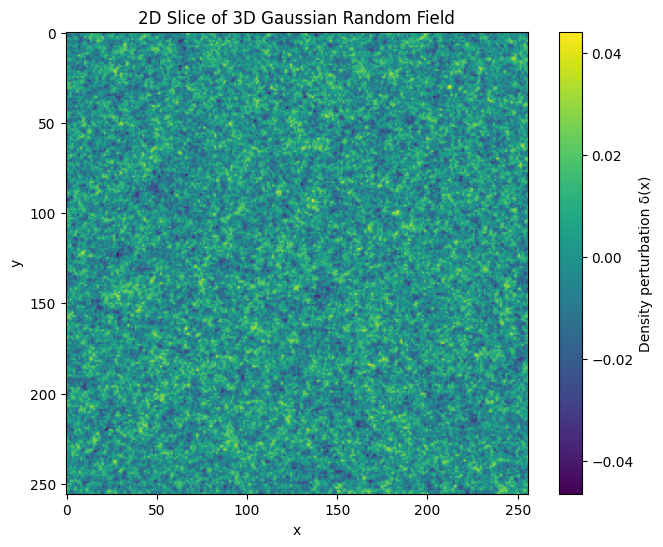

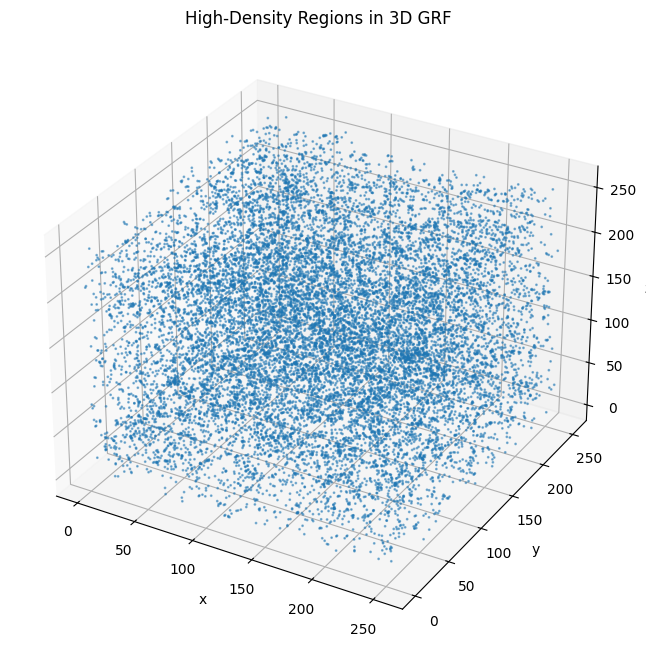

Mean density: 4.804264997707985e-20
Standard deviation: 0.010785497558740666
Min density: -5.712e-02, Max density: 5.723e-02


In [6]:
# Visualization of the density field, a 2D slice.
plt.figure(figsize=(8, 6))
plt.imshow(initial_density_field[N_grid_cells//2, :, :], cmap='viridis')
plt.colorbar(label='Density perturbation δ(x)')
plt.title('2D Slice of 3D Gaussian Random Field')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Also, a 3D scatter plot of the high density regions.
threshold = np.percentile(initial_density_field, 99.9)  # Top 1% density
high_density = np.where(initial_density_field > threshold)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(high_density[0], high_density[1], high_density[2], s=1, alpha=0.5)
ax.set_title('High-Density Regions in 3D GRF')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# Finally, lets print some stats.
print(f"Mean density: {np.mean(initial_density_field)}")
print(f"Standard deviation: {np.std(initial_density_field)}")
print(f"Min density: {np.min(initial_density_field):.3e}, Max density: {np.max(initial_density_field):.3e}")

**Zel'dovich Approximation** remains mostly the same, can do some slight refactoring of the code.

In [7]:
def zeldovich_positions(N):
  displacements = zeldovich(initial_density_field, N)
  grid_1d = np.linspace(0, L, N, endpoint=False)
  qx, qy, qz = np.meshgrid(grid_1d, grid_1d, grid_1d, indexing='ij')
  positions = np.stack([qx, qy, qz], axis=-1).reshape(-1, 3)

  # Interpolating the displacements to the particle grid if N_particles != N_grid_cells.
  if N != N_grid_cells:
    grid_points = np.linspace(0, L, N_grid_cells, endpoint=False)
    interp = RegularGridInterpolator((grid_points, grid_points, grid_points),
                                    displacements.transpose(1, 2, 3, 0))
    disp_at_q = interp(positions)
  else:
    disp_at_q = displacements.transpose(1, 2, 3, 0).reshape(-1, 3)

  positions += disp_at_q
  return positions

def zeldovich_velocities(N):
  displacements = zeldovich(initial_density_field, N)
  # Interpolating the displacements to the particle grid if N_particles != N_grid_cells
  if N != N_grid_cells:
    grid_points = np.linspace(0, L, N_grid_cells, endpoint=False)
    interp = RegularGridInterpolator((grid_points, grid_points, grid_points),
                                    displacements.transpose(1, 2, 3, 0))
    disp_at_q = interp(zeldovich_positions(N))
  else:
    disp_at_q = displacements.transpose(1, 2, 3, 0).reshape(-1, 3)

  # Must ensure conversion of units are sound so that the velocities units will be in km/s.
  # Since H_initial is in km/s/Mpc, and displacements is in Mpc/h, can divide H_initial by h
  # so that end result is km/s.
  H_h_units = H_initial / h
  velocities = a * H_h_units * f * disp_at_q
  return velocities

def zeldovich_one_direction(potential_k, k_dir):
  displacement_k = -1j * k_dir * potential_k
  displacement_real = np.real(np.fft.ifftn(displacement_k))
  return displacement_real

def zeldovich(density_field, N):
  density_k = np.fft.fftn(density_field)
  kx, ky, kz, k, k2 = fourier_space(N, L)
  k2[0,0,0] = 1.0      # Avoiding division by 0 at k=0.

  # Gravitational potential.
  potential_k = -density_k / k2
  potential_k[0,0,0] = 0    # Mean displacement = 0.

  displacements = np.zeros((3, N_grid_cells, N_grid_cells, N_grid_cells))
  displacements[0] = zeldovich_one_direction(potential_k, kx)
  displacements[1] = zeldovich_one_direction(potential_k, ky)
  displacements[2] = zeldovich_one_direction(potential_k, kz)
  return displacements

# This just calls our respective positions and velocities functions.
positions = zeldovich_positions(N_particles)
velocities = zeldovich_velocities(N_particles)
print(f"Positions shape: {positions.shape}")
print(f"Velocities shape: {velocities.shape}")

Positions shape: (16777216, 3)
Velocities shape: (16777216, 3)


Improved visualizations for the displaced particle positions, as well as relevant stats.

Number of particles in slice: 851968
Plotting 20000 points for the 2D slice scatter plot.


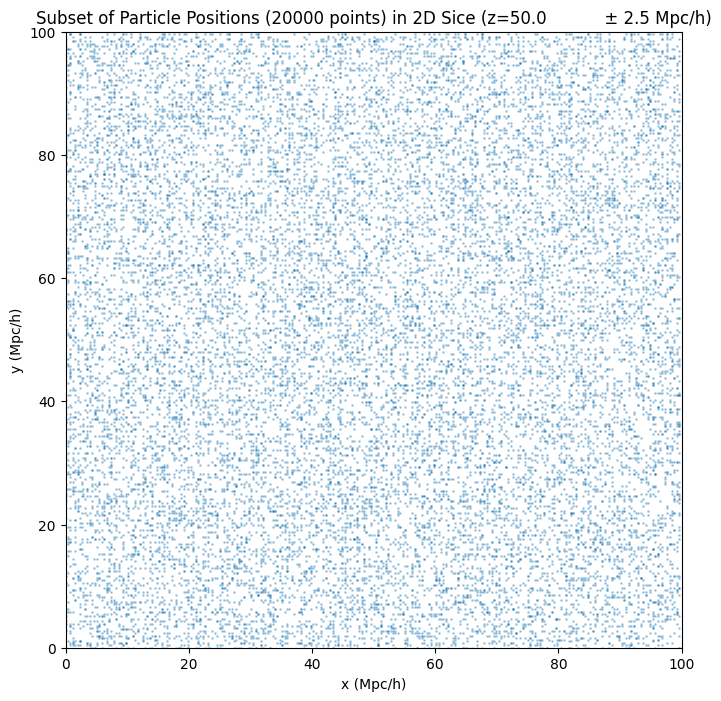

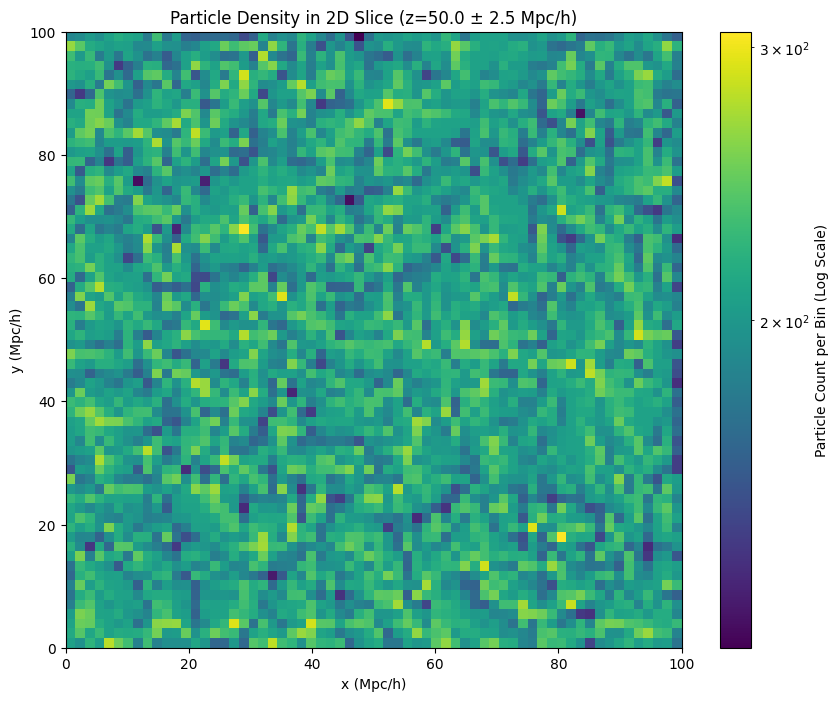

Plotting 20000 points for the overlay plot.


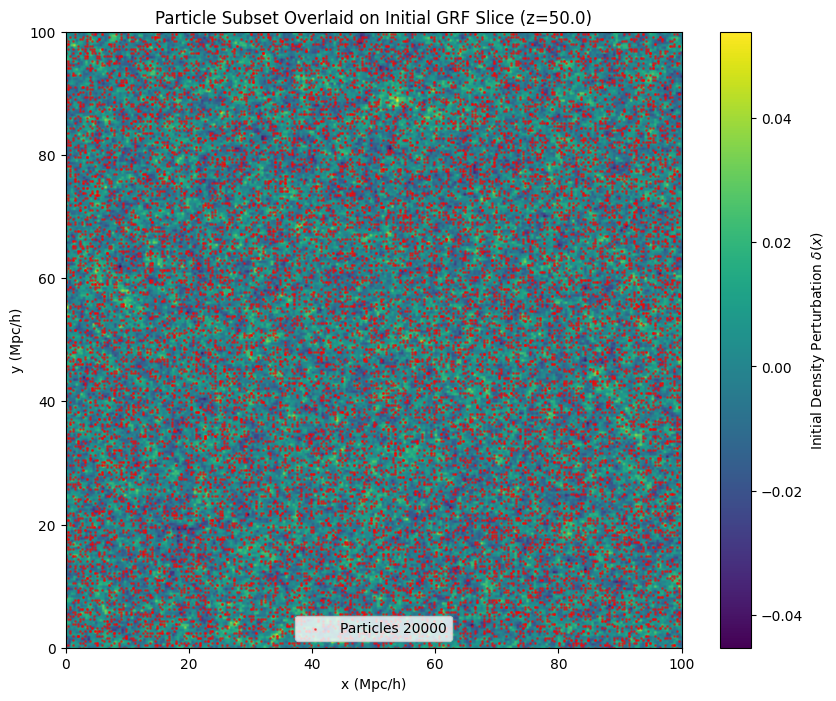

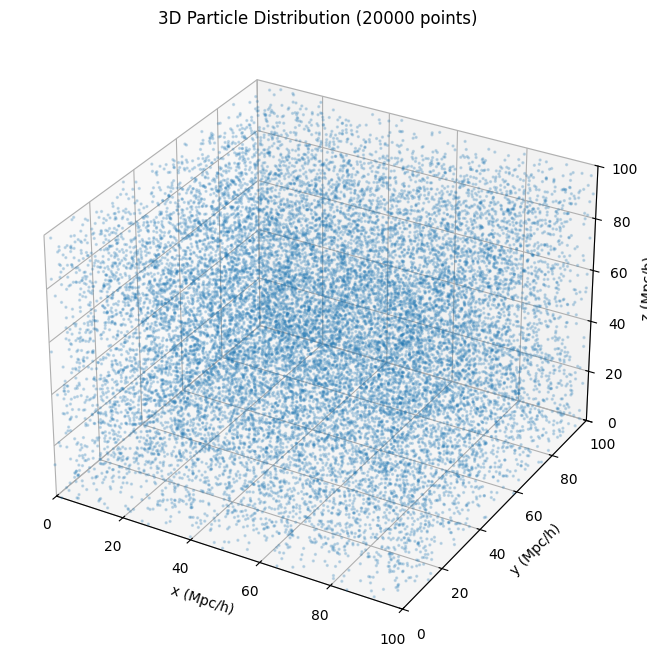

Scale factor a = 0.0100
Growth factor D = 0.0135
Hubble parameter H(a) = 38204.38 km/s/Mpc (proper)
Mean displacement: 5.594e-03 Mpc/h
Max displacement: 1.962e-02 Mpc/h
Mean velocity: 3.1088 km/s
Max velocity: 10.9025 km/s
Grid spacing h = 0.391 Mpc/h
Max displacement as fraction of h: 5.023e-02


In [8]:
# 2D slice of the particles along one dimension, z-axis
# --- Improved 2D Slice Visualization ---

# Define slice parameters
slice_center_z = L / 2.0  # Center of the box
slice_thickness = L / 20.0 # Adjust thickness as needed (e.g., 5% of box)
z_min = slice_center_z - slice_thickness / 2.0
z_max = slice_center_z + slice_thickness / 2.0

# Select particles within the z-slice
in_slice = (positions[:, 2] >= z_min) & (positions[:, 2] < z_max)
positions_slice = positions[in_slice]

print(f"Number of particles in slice: {len(positions_slice)}") # Check how many points.

n_slice_scatter_points = 20000
if n_slice_scatter_points > len(positions_slice):
  n_slice_scatter_points = len(positions_slice)

# Randomly choosing indices from the particles already in the slice.
subset_indices_scatter = np.random.choice(len(positions_slice), n_slice_scatter_points, replace=False)
positions_slice_subset = positions_slice[subset_indices_scatter]

print(f"Plotting {n_slice_scatter_points} points for the 2D slice scatter plot.")

plt.figure(figsize=(10, 8))

# Plotting only the subset of particles.
plt.scatter(positions_slice_subset[:, 0], positions_slice_subset[:, 1], s=1, alpha=0.3) # Increase alpha
plt.title(f"Subset of Particle Positions ({n_slice_scatter_points} points) in 2D Sice (z={slice_center_z:.1f} \
          ± {slice_thickness/2.0:.1f} Mpc/h)")
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.xlim(0, L)
plt.ylim(0, L)
plt.gca().set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
plt.show()

# 2D Heatmap of the density perturbations.
from matplotlib.colors import LogNorm # Import LogNorm

plt.figure(figsize=(10, 8))
# Adjust bins as needed, maybe N/4 or N/2?
nbins = N_particles // 4
plt.hist2d(positions_slice[:, 0], positions_slice[:, 1],
           bins=nbins,           # Number of bins in each dimension
           range=[[0, L], [0, L]], # Explicitly set range
           cmap='viridis',        # Or 'inferno', 'magma'
           norm=LogNorm())      # Use LogNorm to see high and low densities! Essential.

plt.colorbar(label='Particle Count per Bin (Log Scale)')
plt.title(f"Particle Density in 2D Slice (z={slice_center_z:.1f} ± {slice_thickness/2.0:.1f} Mpc/h)")
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Overlay slice on the GRF slice. Will compare positions directly on the initial density field
# --- Overlay Particle Slice on GRF Slice ---

# First, get the corresponding slice from the initial density field
# Ensure 'initial_density_field' is the real-space delta field computed BEFORE Zeldovich
# If you have field_k, compute: initial_density_field = np.real(np.fft.ifftn(field_k))
# NOTE: Ensure field_k used here was correctly normalized and scaled by D(z_start)

slice_index_z = int(N_particles * (slice_center_z / L)) # Find grid index for slice center
grf_slice = initial_density_field[:, :, slice_index_z] # Assuming shape (Nx, Ny, Nz) - adjust if needed!

# Plotting only subset of particles from the slice.
n_overlay_points = 20000
if n_overlay_points > len(positions_slice):
  n_overlay_points = len(positions_slice)

# Randomly choosing indices from the particles already in the slice,
subset_indices_overlay = np.random.choice(len(positions_slice), n_overlay_points, replace=False)
positions_overlay_subset = positions_slice[subset_indices_overlay]

print(f"Plotting {n_overlay_points} points for the overlay plot.")

plt.figure(figsize=(10, 8))

# Plot the GRF slice first
plt.imshow(grf_slice.T, # Transpose if necessary depending on meshgrid/imshow conventions
           cmap='viridis', # Or another diverging map like 'coolwarm'
           origin='lower',
           extent=[0, L, 0, L],
           aspect='equal')
plt.colorbar(label='Initial Density Perturbation $\delta(x)$')

# Overlay the subset of particles.
plt.scatter(positions_overlay_subset[:, 0], positions_overlay_subset[:, 1],
            s=1,              # Can adjust for smaller point size.
            alpha=0.5,
            c='red',
            label=f'Particles {n_overlay_points}') # Updating label.

plt.title(f"Particle Subset Overlaid on Initial GRF Slice (z={slice_center_z:.1f})")
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.xlim(0, L)
plt.ylim(0, L)
plt.legend()
plt.show()

# Plotting a 3D scatter of a subset of particles.
# --- Improved 3D Scatter Plot ---

# Increase the number of points in the subset
n_subset_3d = 20000 # Try 10k, 20k, 50k - depends on performance
if n_subset_3d > len(positions):
    n_subset_3d = len(positions) # Don't request more than available

subset_indices = np.random.choice(len(positions), n_subset_3d, replace=False)
positions_subset_3d = positions[subset_indices]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Adjust size and alpha if needed
ax.scatter(positions_subset_3d[:, 0], positions_subset_3d[:, 1], positions_subset_3d[:, 2],
           s=2, alpha=0.2) # Smaller points, maybe lower alpha if dense
ax.set_title(f"3D Particle Distribution ({n_subset_3d} points)")
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)')
# Set limits to box size for context
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_zlim(0, L)
plt.show()


print(f"Scale factor a = {a:.4f}")
print(f"Growth factor D = {D_numerical:.4f}")
print(f"Hubble parameter H(a) = {H_initial:.2f} km/s/Mpc (proper)")

# Should be a small magnitude, ranging from 0.1 or 0.01.
print(f"Mean displacement: {np.mean(np.sqrt(np.sum(zeldovich(initial_density_field, N_particles)**2, axis=0))):.3e} Mpc/h")
print(f"Max displacement: {np.max(np.sqrt(np.sum(zeldovich(initial_density_field, N_particles)**2, axis=0))):.3e} Mpc/h")
print(f"Mean velocity: {np.mean(np.sqrt(np.sum(velocities**2, axis=1))):.4f} km/s")
print(f"Max velocity: {np.max(np.sqrt(np.sum(velocities**2, axis=1))):.4f} km/s")

# Compare to grid spacing.
h = L / N_grid_cells
print(f"Grid spacing h = {h:.3f} Mpc/h")
print(f"Max displacement as fraction of h: {np.max(np.sqrt(np.sum(zeldovich(initial_density_field, N_particles)**2, axis=0))) / h:.3e}")

**Initial CIC Intepolation** remains the same, no changes necessary.

In [10]:
def cic_initial(positions, N, L):
  # Simulation's grid spacing initialization, followed by wrapping of the positions
  # to handle periodic boundary conditions.
  h = L / N
  wrapped_pos = positions % L

  # Usage of integer floor function on particle coords to get the patent cell indices.
  # Computation of normalized distances and subsequent weights for each dimension.
  xp, yp, zp = wrapped_pos[:, 0]/h, wrapped_pos[:, 1]/h, wrapped_pos[:, 2]/h
  xc, yc, zc = xp.astype(int), yp.astype(int), zp.astype(int)
  dx, dy, dz = xp-xc, yp-yc, zp-zc
  tx, ty, tz = 1-dx, 1-dy, 1-dz

  # Usage of weights for each dimension for computation of the weights for the 8 neighboring
  # grid points. These represents the contributions of each weight to their respective points.
  w000 = tx * ty * tz
  w100 = dx * ty * tz
  w010 = tx * dy * tz
  w001 = tx * ty * dz
  w110 = dx * dy * tz
  w011 = tx * dy * dz
  w101 = dx * ty * dz
  w111 = dx * dy * dz

  # Initialization of new density grid, as well as grid's indicies using our parent cell indices.
  # Making sure we take into account periodicity.
  density_grid = np.zeros((N, N, N))
  i0, i1 = xc % N, (xc+1) % N
  j0, j1 = yc % N, (yc+1) % N
  k0, k1 = zc % N, (zc+1) % N

  # Particle mass assignment to the its 8 respective neighboring grid points.
  # As of now, lets keep particle's mass to be 1.
  mp = 1
  np.add.at(density_grid, (i0, j0, k0), mp * w000)
  np.add.at(density_grid, (i1, j0, k0), mp * w100)
  np.add.at(density_grid, (i0, j1, k0), mp * w010)
  np.add.at(density_grid, (i0, j0, k1), mp * w001)
  np.add.at(density_grid, (i1, j1, k0), mp * w110)
  np.add.at(density_grid, (i0, j1, k1), mp * w011)
  np.add.at(density_grid, (i1, j0, k1), mp * w101)
  np.add.at(density_grid, (i1, j1, k1), mp * w111)

  # The result is our density grid where each point's value is the total mass
  # assigned to it, based on the weight's contribution at that specific grid point.
  # Remember, the weight is determined by the distance of the particle from that point.
  return density_grid

cic_density_field = cic_initial(positions, N_grid_cells, L)
mean_density = np.mean(cic_density_field)
delta_cic_density_field = cic_density_field / mean_density - 1

# The mean density should be close to 1, since N_part = N
print(f"Mean density from CIC (particles per grid point): {mean_density:.3f}")
print(f"Total mass assigned: {np.sum(cic_density_field):.1f} (should equal N_part^3 = {N_particles**3})")
max_delta = np.max(delta_cic_density_field)
min_delta = np.min(delta_cic_density_field)
print(f"Debug: Max delta = {max_delta:.4e}, Min delta = {min_delta:.4e}")

Mean density from CIC (particles per grid point): 1.000
Total mass assigned: 16777216.0 (should equal N_part^3 = 16777216)
Debug: Max delta = 7.0433e-02, Min delta = -3.8670e-02


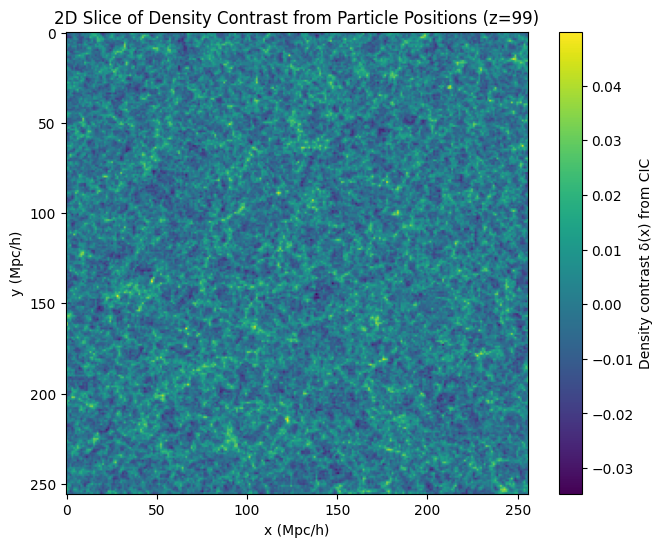

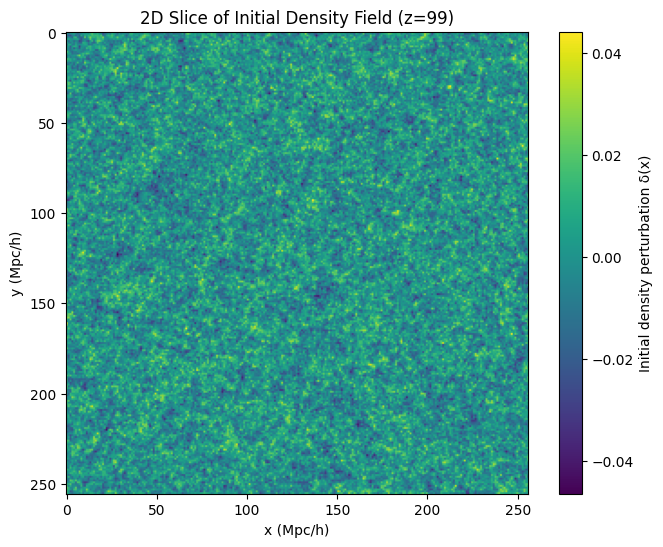

Standard deviation of initial δ: 1.079e-02
Standard deviation of CIC δ: 8.798e-03


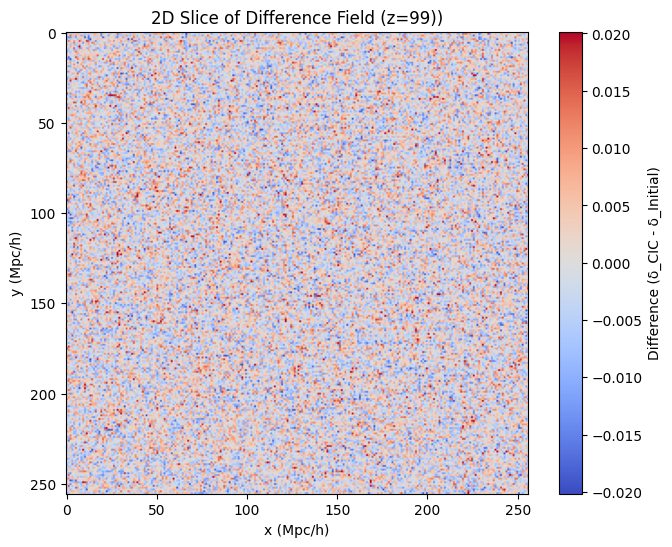

Standard deviation of the Difference Field: 6.716e-03


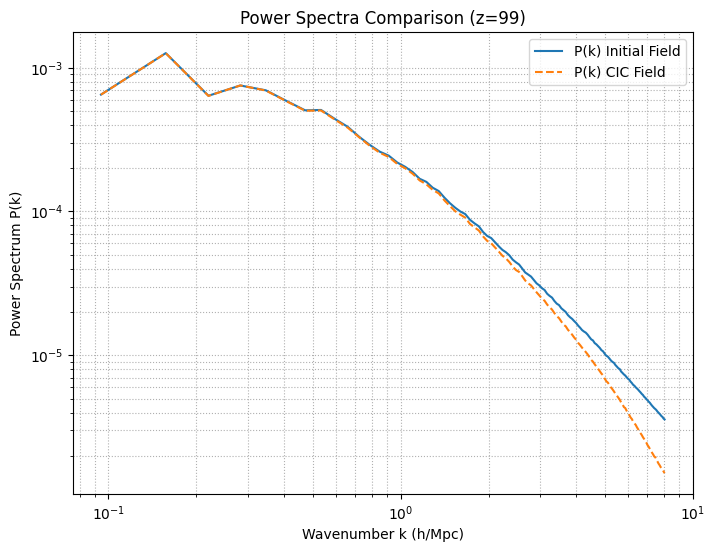

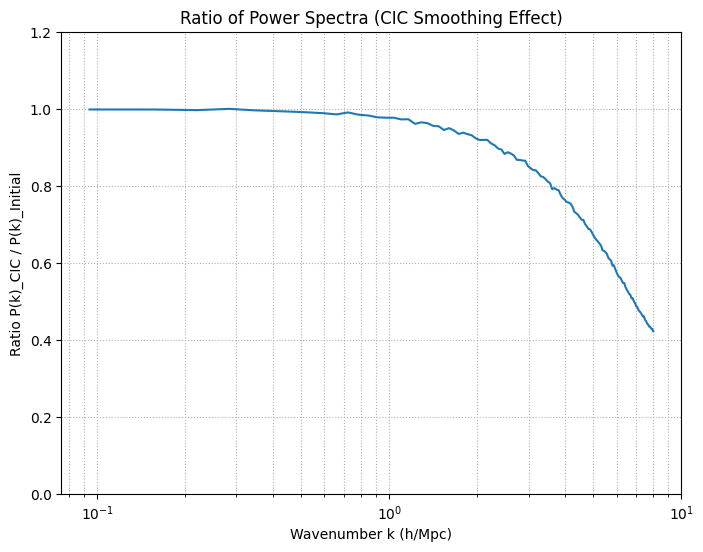

In [ ]:
# Visualizations:
# Plot a 2D slice of the CIC density contrast
plt.figure(figsize=(8, 6))
plt.imshow(delta_cic_density_field[N_grid_cells//2, :, :], cmap='viridis')
plt.colorbar(label='Density contrast δ(x) from CIC')
plt.title('2D Slice of Density Contrast from Particle Positions (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Plot the initial density field for comparison
plt.figure(figsize=(8, 6))
plt.imshow(initial_density_field[N_grid_cells//2, :, :], cmap='viridis')
plt.colorbar(label='Initial density perturbation δ(x)')
plt.title('2D Slice of Initial Density Field (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Compare statistics
print(f"Standard deviation of initial δ: {np.std(initial_density_field):.3e}")
print(f"Standard deviation of CIC δ: {np.std(delta_cic_density_field):.3e}")

# Lets create a difference plot to highlight the differences between the initial and
# CIC density field.
diff_field = delta_cic_density_field - initial_density_field

# We can set the min and max std variations for the difference field.
diff_std = np.std(diff_field)
vmin_diff = -3 * diff_std
vmax_diff = 3 * diff_std

plt.figure(figsize=(8, 6))
slice_index = N_grid_cells // 2
plt.imshow(diff_field[slice_index, :, :],
           cmap='coolwarm',
           vmin=vmin_diff,
           vmax=vmax_diff)
plt.colorbar(label='Difference (δ_CIC - δ_Initial)')
plt.title(f'2D Slice of Difference Field (z=99))')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

print(f"Standard deviation of the Difference Field: {diff_std:.3e}")

# Power Spectra Comparison between the initial and CIC field.
import numpy as np

def calculate_power_spectrum_1d(field_3d, L_box, N_grid):
    """Calculates the spherically averaged 1D power spectrum P(k)."""
    if field_3d.shape != (N_grid, N_grid, N_grid):
        raise ValueError(f"Input field must have shape ({N_grid},{N_grid},{N_grid})")

    delta_k = np.fft.fftn(field_3d)
    # Power spectrum P(k) = |delta_k|^2 * (L/N^2)^3 (or similar normalization)
    # Using numpy-fft convention: Normalization is 1/N^3 for ifftn
    # So |delta_k|^2 needs scaling by (L/N)^3 / N^3 = L^3 / N^6 ? Let's check standard def.
    # Often P(k) = V * <|delta_k|^2> / N^6 where V=L^3
    pk_3d = np.abs(delta_k)**2 * (L_box**3) / (N_grid**6)

    # Calculate k modes
    k_nyquist = np.pi * N_grid / L_box
    k_coords = np.fft.fftfreq(N_grid) * 2 * np.pi * N_grid / L_box # k = 2pi*n/L
    kx, ky, kz = np.meshgrid(k_coords, k_coords, k_coords, indexing='ij')
    k_magnitude = np.sqrt(kx**2 + ky**2 + kz**2)

    # Binning P(k)
    k_bins = np.linspace(0, k_nyquist, N_grid // 2 + 1)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])

    # Histogram P(k) values into k bins
    # The np.histogram function returns only 2 values (hist, bin_edges) when density=False
    # Change the line to unpack only 2 values.
    pk_1d, _ = np.histogram(
        k_magnitude.flatten(),
        bins=k_bins,
        weights=pk_3d.flatten(),
        density=False
    )

    # Count number of modes in each bin
    counts, _ = np.histogram(
        k_magnitude.flatten(),
        bins=k_bins,
        weights=None,
        density=False
    )

    # Average P(k) in each bin
    pk_1d_avg = np.divide(pk_1d, counts, where=counts > 0, out=np.zeros_like(pk_1d))

    # Often we exclude the k=0 mode (average density)
    return k_bin_centers[1:], pk_1d_avg[1:] # Skip first bin (contains k=0)

# --- Calculate Power Spectra ---
k_initial, pk_initial = calculate_power_spectrum_1d(initial_density_field, L, N_grid_cells)
k_cic, pk_cic = calculate_power_spectrum_1d(delta_cic_density_field, L, N_grid_cells)

# --- Plot Power Spectra ---
plt.figure(figsize=(8, 6))
plt.loglog(k_initial, pk_initial, label='P(k) Initial Field')
plt.loglog(k_cic, pk_cic, label='P(k) CIC Field', linestyle='--')

plt.xlabel('Wavenumber k (h/Mpc)')
plt.ylabel('Power Spectrum P(k)')
plt.title('Power Spectra Comparison (z=99)')
plt.legend()
plt.grid(True, which='both', linestyle=':')
plt.show()

# Optional: Plot the ratio of P(k) to see the CIC window function effect
# Need to interpolate one P(k) onto the other's k-bins if they differ slightly
from scipy.interpolate import interp1d
interp_pk_initial = interp1d(k_initial, pk_initial, bounds_error=False, fill_value=0)
ratio_pk = pk_cic / interp_pk_initial(k_cic)

plt.figure(figsize=(8, 6))
plt.semilogx(k_cic, ratio_pk)
plt.xlabel('Wavenumber k (h/Mpc)')
plt.ylabel('Ratio P(k)_CIC / P(k)_Initial')
plt.title('Ratio of Power Spectra (CIC Smoothing Effect)')
plt.ylim(0, 1.2) # Expect ratio <= 1
plt.grid(True, which='both', linestyle=':')
plt.show()

**CIC Force Interpolation** remains mostly the same, can explicitly define functions for the comoving and physical accelerations

In [ ]:
# Conversion constants used for conversions.
Mpc_to_km = (1 * u.Mpc).to(u.km).value
Myr_to_s = (1 * u.Myr).to(u.s).value
#km_s_Myr_to_Mpc_h_Myr2 = (u.km / u.s / u.Myr).to(u.Mpc / u.Myr**2 / h).value
Mpc_h_to_km = (1 * u.Mpc / h).to(u.km).value

def cic_grav_force(force, positions, N , L):
  h = L / N
  wrapped_pos = positions % L
  xp, yp, zp = wrapped_pos[:, 0]/h, wrapped_pos[:, 1]/h, wrapped_pos[:, 2]/h
  xc, yc, zc = np.floor(xp).astype(int), np.floor(yp).astype(int), np.floor(zp).astype(int)
  dx, dy, dz = xp-xc, yp-yc, zp-zc
  tx, ty, tz = 1-dx, 1-dy, 1-dz
  # Grid cell indices via our parent cell indices, taking into account periodic boundary conds.
  i0, i1 = xc % N, (xc+1) % N
  j0, j1 = yc % N, (yc+1) % N
  k0, k1 = zc % N, (zc+1) % N

  # Fetching the field values at the 8 neighboring grid points.
  f000 = force[i0, j0, k0]
  f100 = force[i1, j0, k0]
  f010 = force[i0, j1, k0]
  f001 = force[i0, j0, k1]
  f110 = force[i1, j1, k0]
  f011 = force[i0, j1, k1]
  f101 = force[i1, j0, k1]
  f111 = force[i1, j1, k1]

  # Getting the acceleration for each particle, whereby each particle's acceleration is a
  # weighted avg of the forces at the 8 neighboring grid points. (gathering the grid's forces
  # to the particle)
  interpolated = (
    f000 * tx * ty * tz +
    f100 * dx * ty * tz +
    f010 * tx * dy * tz +
    f001 * tx * ty * dz +
    f110 * dx * dy * tz +
    f011 * tx * dy * dz +
    f101 * dx * ty * dz +
    f111 * dx * dy * dz
  )
  return interpolated


# Getting the comoving accelerations a_grav.
def comoving_accelerations(positions, N_grid_cells, L):
  delta_cic_density_field = cic_initial(positions, N_grid_cells, L)
  mean_density = np.mean(delta_cic_density_field)
  delta_cic_density_field = delta_cic_density_field / mean_density - 1

  gravitational_forces = zeldovich(delta_cic_density_field, N_grid_cells)
  accel_x, accel_y, accel_z = cic_grav_force(gravitational_forces[0], positions, N_grid_cells, L), \
                              cic_grav_force(gravitational_forces[1], positions, N_grid_cells, L), \
                              cic_grav_force(gravitational_forces[2], positions, N_grid_cells, L)
  a_grav = np.stack([accel_x, accel_y, accel_z], axis=1)
  return a_grav       # In comoving (simulation) units Mpc/h.

# Getting the physical accelerations via a_grav conversion. Thus: Mpc/h to km/s/Myr.
def physical_accelerations(a_grav, positions, N_grid_cells, L, a_current, cosmo_obj):
  # Factor for physcial conversion: (3 * omega_m * H0^2) / (2 * a^2).
  H0_kms_Mpc = cosmo_obj.H0.to(u.km / u.s / u.Mpc).value
  physical_factor = (3 * cosmo_obj.Om0 * H0_kms_Mpc**2) / (2 * a_current**2) # Units: (km/s/Mpc)^2
  a_phys = a_grav * physical_factor # Units: (km/s/Mpc)^2 * (Mpc/h)

  # Now that our comoving accels are in physcial units, will now have to convert it into its physical time
  # unit equivalent in order to do the leapfrog integration (km/s/Myr).
  phys_conversion = Myr_to_s / (Mpc_to_km / h) # s/Myr * (Mpc*h)/km
  a_phys_time = a_phys * phys_conversion
  return a_phys_time # Should be in km/s/Myr

a_grav = comoving_accelerations(positions, N_grid_cells, L)
a_phys = physical_accelerations(a_grav, positions, N_grid_cells, L, a_initial, cosmo)

In [ ]:
print(f"Comoving Accelerations shape: {a_grav.shape}")
print(f"Physical Accelerations shape: {a_phys.shape}")

accel_magnitude = np.sqrt(np.sum(a_grav**2, axis=1))
print(f"Mean comoving acceleration: {np.mean(accel_magnitude):.3e} (simulation units)")
print(f"Max comoving acceleration: {np.max(accel_magnitude):.3e} (simulation units)")

Comoving Accelerations shape: (16777216, 3)
Physical Accelerations shape: (16777216, 3)
Mean comoving acceleration: 5.444e-03 (simulation units)
Max comoving acceleration: 1.980e-02 (simulation units)


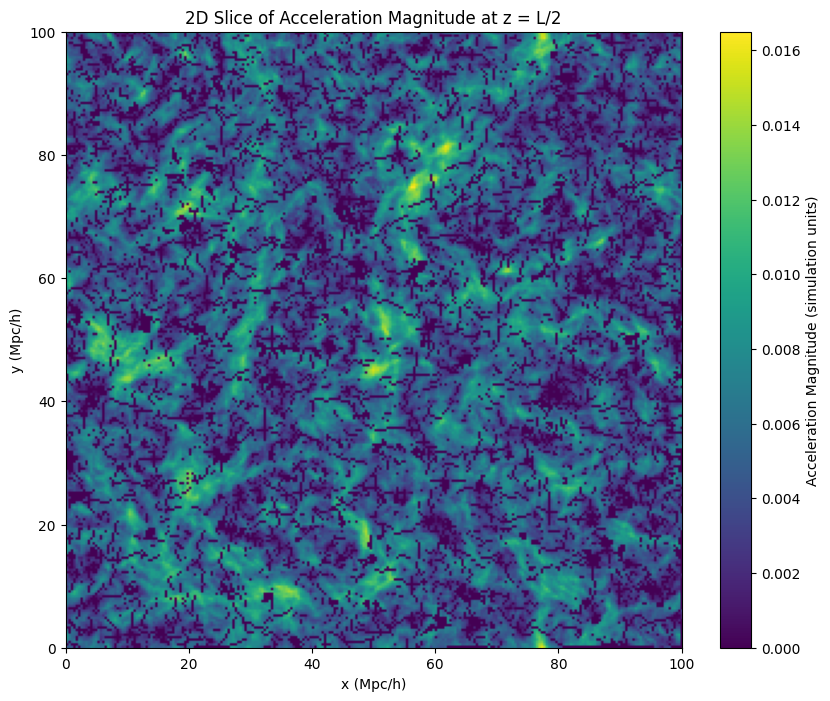

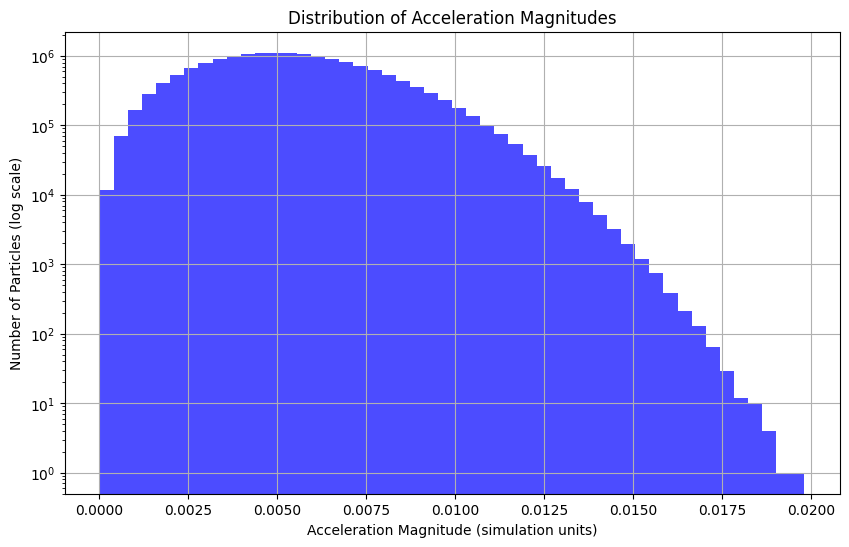

In [ ]:
# 2D Acceleration Magnitude Map:
# Compute acceleration magnitudes
accel_magnitude = np.sqrt(np.sum(a_grav**2, axis=1))

# Define a function to grid the magnitudes (similar to CIC but simpler averaging)
def grid_magnitudes(positions, magnitudes, N, L):
    h = L / N
    grid = np.zeros((N, N, N))
    counts = np.zeros((N, N, N))
    indices = (positions / h).astype(int) % N  # Grid indices with periodic boundaries
    np.add.at(grid, (indices[:, 0], indices[:, 1], indices[:, 2]), magnitudes)
    np.add.at(counts, (indices[:, 0], indices[:, 1], indices[:, 2]), 1)
    counts[counts == 0] = 1  # Avoid division by zero
    return grid / counts

# Grid the acceleration magnitudes
accel_grid = grid_magnitudes(positions, accel_magnitude, N_grid_cells, L)

# Plot a 2D slice
plt.figure(figsize=(10, 8))
plt.imshow(accel_grid[N_grid_cells//2, :, :], cmap='viridis', extent=[0, L, 0, L])
plt.colorbar(label='Acceleration Magnitude (simulation units)')
plt.title('2D Slice of Acceleration Magnitude at z = L/2')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Histogram of the Acceleration Magnitudes:
# Compute acceleration magnitudes (if not already done)
accel_magnitude = np.sqrt(np.sum(a_grav**2, axis=1))

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(accel_magnitude, bins=50, log=True, color='blue', alpha=0.7)
plt.title('Distribution of Acceleration Magnitudes')
plt.xlabel('Acceleration Magnitude (simulation units)')
plt.ylabel('Number of Particles (log scale)')
plt.grid(True)
plt.show()

**Leapfrog Integration: Euler's Method for Scaling Factor Update**

In [ ]:
def leapfrog_euler(initial_positions, initial_velocities, N_grid, L, delta_t_myr, num_steps, a_init, cosmo_obj):
  positions_history = [initial_positions.copy()]
  velocities_current = initial_velocities.copy()
  positions_current = initial_positions.copy()
  a_current = a_init
  h_cosmo = cosmo_obj.h

  print(f"Starting Euler's Leapfrog Integration:")
  print(f"Timestep dt: {delta_t_myr} Myr")
  print(f"Number of steps: {num_steps}")
  print(f"Initial scale factor a: {a_current:.4f}")

  # Initial conditions:
  z_current = 1.0 / a_current - 1.0
  H_current_kmsMpc = cosmo_obj.H(z_current).to(u.km / u.s / u.Mpc).value
  # Hubble parameter in 1/Myr:
  H_current_Myr = H_current_kmsMpc * (u.km / u.s / u.Mpc).to(1 / u.Myr)
  print(f"Initial Hubble parameter H(a): {H_current_kmsMpc:.2f} km/s/Mpc to {H_current_Myr} 1/Myr")

  a_grav = comoving_accelerations(initial_positions, N_grid_cells, L)
  a_phys = physical_accelerations(a_grav, initial_positions, N_grid_cells, L, a_current, cosmo_obj)

  # Integration Loop:
  for step in range (num_steps):
    # Kick1: Half-step velocity update.
    velocities_current += (-H_current_Myr * velocities_current + a_phys) * (delta_t_myr / 2.0)

    # Drift: Full-step position update.
    conversion_vel_pos = (u.km/u.s * u.Myr).to(u.Mpc / h_cosmo) #(km/s * Myr)
    positions_current += (velocities_current / a_current) * delta_t_myr * conversion_vel_pos
    positions_current %= L

    # Updating scaling factor a via Euler's Method, Hubble param update, computing new accelerations.
    a_current += H_current_Myr * a_current * delta_t_myr
    z_current = 1.0 / a_current - 1.0
    if z_current < 0: z_current = 0
    H_current_kmsMpc = cosmo_obj.H(z_current).to(u.km / u.s / u.Mpc).value
    H_current_Myr = H_current_kmsMpc * (u.km / u.s / u.Mpc).to(1 / u.Myr)
    a_grav = comoving_accelerations(positions_current, N_grid_cells, L)
    a_phys = physical_accelerations(a_grav, positions_current, N_grid_cells, L, a_current, cosmo_obj)

    # Kick2: Second half-step velocity update.
    velocities_current += (-H_current_Myr * velocities_current + a_phys) * (delta_t_myr / 2.0)

    # Storing the current positions for future usage.
    positions_history.append(positions_current.copy())
    #if (step + 1) % 50 == 0: # Print status less often
      #print(f"Euler Step {step+1}/{num_steps}: a = {a_current:.6f}, z = {z_current:.3f}, H = {H_current_kmsMpc:.2f} km/s/Mpc")
    print(f"Euler Step {step+1}: a = {a_current:.6f}, H = {H_current_kmsMpc:.2f} km/s/Mpc")

  print(f"Finished Euler Leapfrog. Final a = {a_current:.6f}")
  return positions_history, velocities_current, positions_current

# --- Run the Simulation (Euler Example) ---
print("\nRunning Euler Integration")
pos_history_euler, final_velocity_euler, final_position_euler = leapfrog_euler(
    positions, velocities, N_grid_cells, L, delta_t, num_steps, a, cosmo
)



Running Euler Integration
Starting Euler's Leapfrog Integration:
Timestep dt: 0.1 Myr
Number of steps: 100
Initial scale factor a: 0.0100
Initial Hubble parameter H(a): 38204.38 km/s/Mpc to 0.039072082995943926 1/Myr
Euler Step 1: a = 0.010039, H = 37979.44 km/s/Mpc
Euler Step 2: a = 0.010078, H = 37757.15 km/s/Mpc
Euler Step 3: a = 0.010117, H = 37537.45 km/s/Mpc
Euler Step 4: a = 0.010156, H = 37320.30 km/s/Mpc
Euler Step 5: a = 0.010195, H = 37105.66 km/s/Mpc
Euler Step 6: a = 0.010233, H = 36893.48 km/s/Mpc
Euler Step 7: a = 0.010272, H = 36683.73 km/s/Mpc
Euler Step 8: a = 0.010310, H = 36476.35 km/s/Mpc
Euler Step 9: a = 0.010349, H = 36271.31 km/s/Mpc
Euler Step 10: a = 0.010387, H = 36068.58 km/s/Mpc
Euler Step 11: a = 0.010426, H = 35868.10 km/s/Mpc
Euler Step 12: a = 0.010464, H = 35669.85 km/s/Mpc
Euler Step 13: a = 0.010502, H = 35473.78 km/s/Mpc
Euler Step 14: a = 0.010540, H = 35279.87 km/s/Mpc
Euler Step 15: a = 0.010578, H = 35088.07 km/s/Mpc
Euler Step 16: a = 0.01061

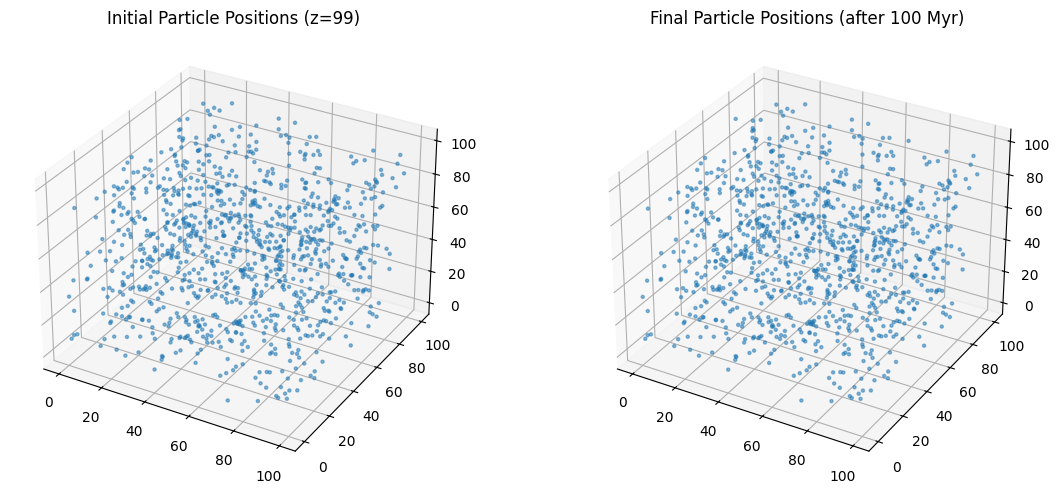

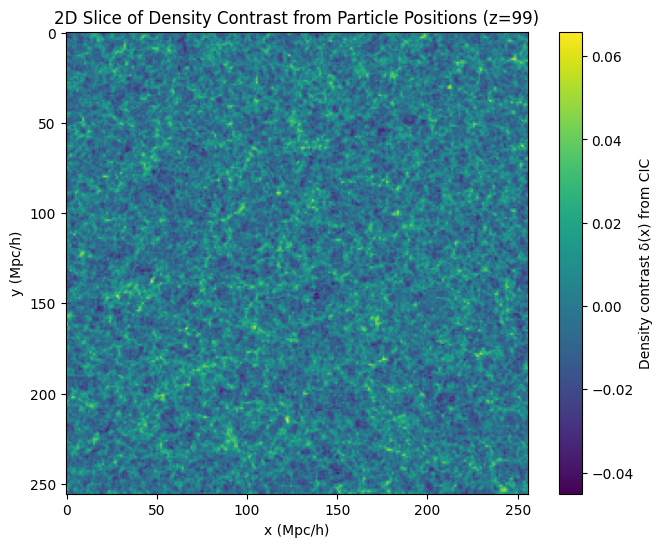

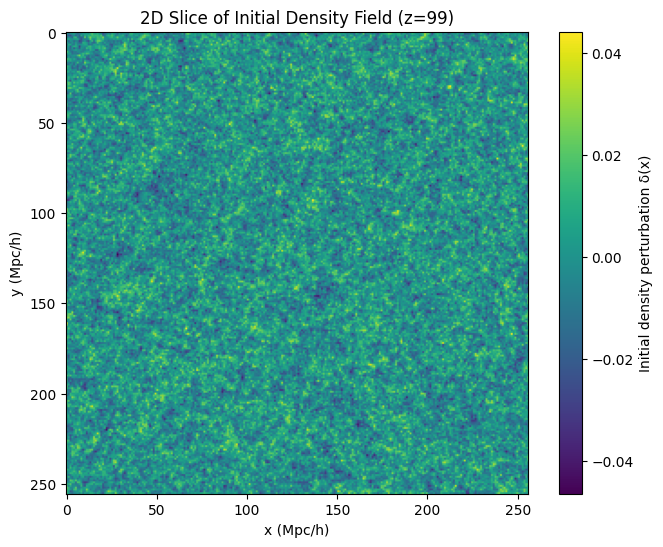

Standard deviation of initial δ: 1.079e-02
Standard deviation of CIC δ: 1.149e-02


In [ ]:
# Visualizations for Euler's Integration:
subset = np.random.choice(len(positions), 1000, replace=False)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pos_history_euler[0][subset, 0], pos_history_euler[0][subset, 1],
           pos_history_euler[0][subset, 2], s=5, alpha=0.5)
ax1.set_title("Initial Particle Positions (z=99)")
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(final_position_euler[subset, 0], final_position_euler[subset, 1],
           final_position_euler[subset, 2], s=5, alpha=0.5)
ax2.set_title("Final Particle Positions (after 100 Myr)")
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are defined from your simulation:
# - positions_history: list of particle positions at each timestep, with positions_history[-1] being the final positions
# - N: grid size (e.g., 128 for a 128^3 grid)
# - L: physical box size in Mpc/h
# - a_current: final scale factor after the leapfrog integration
# - cic_interpolation: function that computes the density grid from particle positions

# Step 1: Compute the density grid using CIC interpolation from the final particle positions.
density_final = cic_initial(final_position_euler, N_grid_cells, L)

# Step 2: Calculate the mean density
# Total mass is distributed over N^3 grid cells; mean density is total mass / number of cells
mean_density_final = np.sum(density_final) / (N_grid_cells**3)

# Step 3: Compute the density contrast δ(x) = (ρ(x) / ρ_mean) - 1
delta_final = (density_final / mean_density_final) - 1

# Plot a 2D slice of the CIC density contrast
plt.figure(figsize=(8, 6))
plt.imshow(delta_final[N_grid_cells//2, :, :], cmap='viridis')
plt.colorbar(label='Density contrast δ(x) from CIC')
plt.title('2D Slice of Density Contrast from Particle Positions (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()
plt.show()

# Plot the initial density field for comparison
plt.figure(figsize=(8, 6))
plt.imshow(initial_density_field[N_grid_cells//2, :, :], cmap='viridis')
plt.colorbar(label='Initial density perturbation δ(x)')
plt.title('2D Slice of Initial Density Field (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Compare statistics
print(f"Standard deviation of initial δ: {np.std(initial_density_field):.3e}")
print(f"Standard deviation of CIC δ: {np.std(delta_final):.3e}")